##Loading the UrbanSound8K Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Downloading UrbanSound8K Dataset

In [ ]:
import os
dataset_path = "/content/drive/MyDrive/UrbanSound8K"
os.makedirs(dataset_path, exist_ok=True)


In [2]:

%cd /content/drive/MyDrive/UrbanSound8K


/content/drive/MyDrive/UrbanSound8K


In [3]:
import os
import librosa
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [6]:
base_dir = "/content/drive/MyDrive/UrbanSound8K"
metadata_path = f"{base_dir}/metadata/UrbanSound8K.csv"
metadata = pd.read_csv(metadata_path)
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [7]:
metadata['file_path'] = metadata.apply(
    lambda row: f"{base_dir}/audio/fold{row['fold']}/{row['slice_file_name']}",
    axis=1
)


##EDA(Exploratory Data Analysis)

In [ ]:
metadata.describe()

,fsID,start,end,salience,fold,classID
count,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000,8732.000000
mean,116033.493816,38.645409,42.253312,1.347000,5.385937,4.592877
std,57991.017218,74.292126,74.369669,0.476043,2.846820,2.894544
min,344.000000,0.000000,0.105962,1.000000,1.000000,0.000000
25%,69942.250000,3.000000,6.839398,1.000000,3.000000,2.000000
50%,118279.000000,10.376492,14.000000,1.000000,5.000000,4.000000
75%,166942.000000,35.131372,38.866979,2.000000,8.000000,7.000000
max,209992.000000,600.125356,604.125356,2.000000,10.000000,9.000000


In [ ]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   file_path        8732 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 614.1+ KB


In [8]:
class_map = {
    0: "air_conditioner",
    1: "car_horn",
    2: "children_playing",
    3: "dog_bark",
    4: "drilling",
    5: "engine_idling",
    6: "gun_shot",
    7: "jackhammer",
    8: "siren",
    9: "street_music"
}
metadata["class_name"] = metadata["classID"].map(class_map)


In [ ]:
metadata["class_name"].value_counts()


,count
class_name,
dog_bark,1000
children_playing,1000
air_conditioner,1000
street_music,1000
jackhammer,1000
engine_idling,1000
drilling,1000
siren,929
car_horn,429


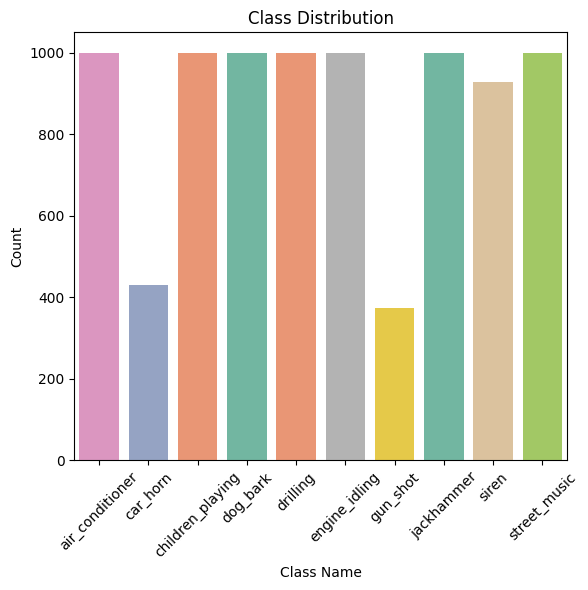

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
#Get the class names and data
metadata["class_name"] = metadata["classID"].map(class_map)
#plot bar graph of class dist
plt.figure(figsize=(6,6))
sns.countplot(x=metadata["class_name"],hue="class_name",data=metadata, order=list(class_map.values()),palette="Set2")
plt.title("Class Distribution")
plt.xlabel("Class Name")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("/content/drive/MyDrive/UrbanSound8K/class_distribution.png")


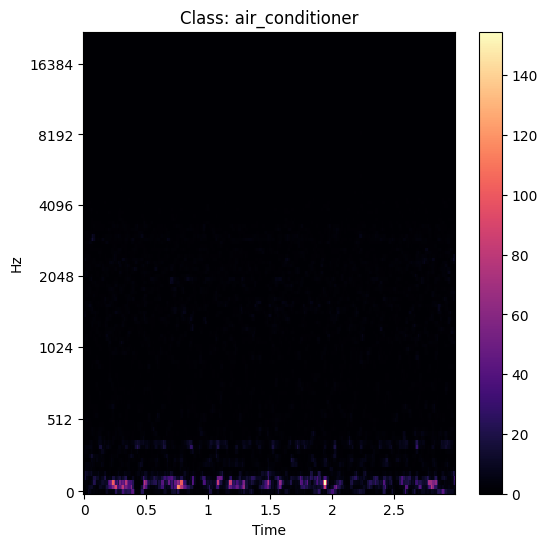

In [ ]:
def show_example(idx):
    #load data
    fp = metadata.loc[idx, "file_path"]
    audio, sr = librosa.load(fp, sr =44000)
    audio = librosa.effects.time_stretch(audio, rate=0.5)

    #Fix the length of the data so its the same
    target_samples = int(3 * 44000)
    audio = librosa.util.fix_length(audio, size=target_samples)
    mel = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    #Plot example
    plt.figure(figsize=(6,6))
    librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
    plt.title(f"Class: {metadata.loc[idx,'class']}")
    bar = plt.colorbar()
    bar.set_label("dB")

    #plt.show()
    #plt.savefig("/content/drive/MyDrive/UrbanSound8K/spectrogram.png")

show_example(25)


###Feature Extraction(Mel-Spectrogram for CNN)

In [3]:
def extract_mel_spectrogram(file_path, target_sr=44000, target_duration=3):
    try:
        #Make sure input is the same for all data
        audio, sr = librosa.load(file_path, sr=target_sr)

        #Time stretching
        #Ensure the stretched audio is also fixed to a specific length
        audio = librosa.effects.time_stretch(audio, rate=0.5)

        #Makes the data the same length by cutting it to fixed size 3 seconds
        target_samples = int(target_duration * target_sr)
        audio = librosa.util.fix_length(audio, size=target_samples)

        #Mel-spectrogram
        #Use fixed sampling rate chose 44000 as it encompases most/all data
        mel = librosa.feature.melspectrogram(y=audio, sr=target_sr)

        #Convert to log scale for better comparison
        mel_db = librosa.power_to_db(mel, ref=np.max)

        return mel_db
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

###Train/Val/Test Split

In [ ]:
X = []
y = []
#Creates the spectrogram data
for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    mel = extract_mel_spectrogram(row['file_path'])
    if mel is not None:
        X.append(mel)
        y.append(row['classID'])


100%|██████████| 8732/8732 [51:49<00:00,  2.81it/s]


In [ ]:
#Creates the arrays of spectrogram data
X = np.array(X)
y = np.array(y)
np.save('/content/drive/MyDrive/spct_data.npy', X)
np.save('/content/drive/MyDrive/label_data.npy', y)
X = X[..., np.newaxis]
np.save('/content/drive/MyDrive/newspct_data.npy', X)


In [9]:
#Train and test split
X = np.load('/content/drive/MyDrive/newspct_data.npy')
y = np.load('/content/drive/MyDrive/label_data.npy')
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=7, stratify=y
)


In [10]:
#Test and validation split
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.5, random_state=7, stratify=y_test
)
#np.save('/content/drive/MyDrive/Test_data.npy', X_test)
#np.save('/content/drive/MyDrive/Test_labels.npy', y_test)

In [11]:
print("Train:", X_train.shape)
print("Val:", X_val.shape)
print("Test:", X_test.shape)


Train: (6112, 128, 258, 1)
Val: (1310, 128, 258, 1)
Test: (1310, 128, 258, 1)


##CNN Training

In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
#Reshape input for CNN should be 128,258,1
input_shape = (X.shape[1], X.shape[2], 1)
print(input_shape)
num_classes = len(np.unique(y))

model = models.Sequential([
    # Convolution layer 1
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=input_shape),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Convolution layer 2
    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Convolution layer 3
    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Colvolution layer 4
    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),

    # Dense layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(num_classes, activation='softmax')
])

# Compile: learning rate tuning, loss, and reporting
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


(128, 258, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 258, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 258, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 129, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 129, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64, 129, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 16, 256)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 458,122 (1.75 MB)

 Trainable params: 457,162 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=21,
    batch_size=32
)


Epoch 1/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - accuracy: 0.3137 - loss: 1.9300 - val_accuracy: 0.3015 - val_loss: 2.0241
Epoch 2/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.5604 - loss: 1.2934 - val_accuracy: 0.5641 - val_loss: 1.3021
Epoch 3/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.6555 - loss: 1.0597 - val_accuracy: 0.5527 - val_loss: 1.2395
Epoch 4/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7060 - loss: 0.9002 - val_accuracy: 0.6779 - val_loss: 0.9388
Epoch 5/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7439 - loss: 0.7723 - val_accuracy: 0.7916 - val_loss: 0.7153
Epoch 6/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7684 - loss: 0.6970 - val_accuracy: 0.7832 - val_loss: 0.6440
Epoch 7/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8006 - loss: 0.6268 - val_accuracy: 0.7374 - val_loss: 0.7658
Epoch 8/21
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.8179 - loss: 0.5876 - val_acc

In [15]:
model.save("/content/drive/MyDrive/CNN_model.keras")

##Model Evaluation

In [14]:
loss, acc = model.evaluate(X_test, y_test)
print("Test accuracy:", acc)


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8822 - loss: 0.3703
Test accuracy: 0.8885496258735657


###Accuracy,Precision,Recall,F1

In [26]:
y_pred = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test, y_pred))


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       150
           1       0.91      0.98      0.95        65
           2       0.89      0.66      0.76       150
           3       0.81      0.88      0.85       150
           4       0.94      0.90      0.92       150
           5       0.92      0.94      0.93       150
           6       0.92      1.00      0.96        56
           7       0.96      0.94      0.95       150
           8       0.87      0.92      0.90       139
           9       0.82      0.91      0.86       150

    accuracy                           0.90      1310
   macro avg       0.90      0.91      0.90      1310
weighted avg       0.90      0.90      0.89      1310



###Confusion Mattrix

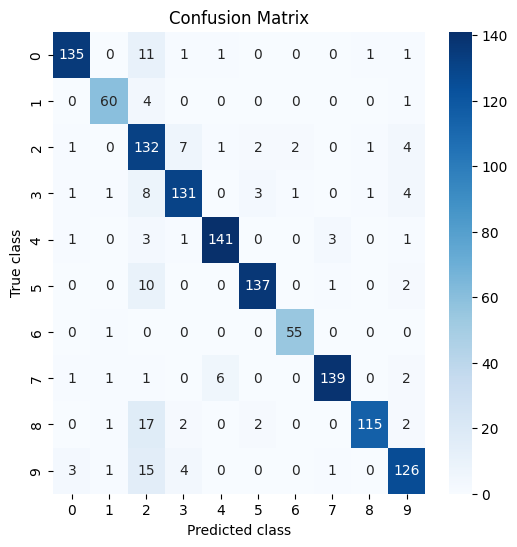

In [ ]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted class")
plt.ylabel("True class")
#plt.show()
plt.savefig("/content/drive/MyDrive/UrbanSound8K/confusion_martix.png")


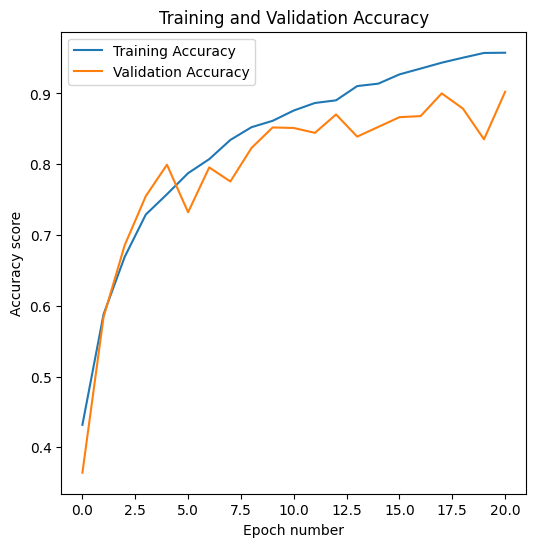

In [30]:
plt.figure(figsize=(6,6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch number')
plt.ylabel('Accuracy score')
plt.legend()
plt.show()
#plt.savefig("/content/drive/MyDrive/UrbanSound8K/train_val_accuracy.png")